# Nutritional Dataset
## Data Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
#from pandas.io.json import json_normalize


# Read CSV file with low_memory=False
nutr_df = pd.read_csv("./data.csv", low_memory=False)
gdp_df = pd.read_csv("./gdp.csv", low_memory=False)

In [2]:
nutr_df.describe()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
count,3.548200e+04,3.532500e+04,3.588900e+04,3.545200e+04,3.548300e+04,3.560300e+04,3.553800e+04,3.602200e+04,3.557700e+04,3.563000e+04,...,5.425500e+04,5.387800e+04,5.443700e+04,5.709900e+04,5.492200e+04,5.492700e+04,5.292400e+04,5.219900e+04,4.306800e+04,0.0
mean,4.398856e+06,4.477329e+06,4.483279e+06,4.634875e+06,4.727806e+06,4.810557e+06,4.923225e+06,4.958680e+06,5.126162e+06,5.229267e+06,...,1.066701e+08,1.178440e+08,1.194416e+08,1.202183e+08,1.354606e+08,1.381746e+08,1.470674e+08,1.534580e+08,9.105685e+06,NaN
std,4.948245e+07,5.013205e+07,5.054473e+07,5.192122e+07,5.297849e+07,5.401988e+07,5.526006e+07,5.607026e+07,5.763263e+07,5.887277e+07,...,1.017662e+10,1.077350e+10,1.114136e+10,1.132855e+10,1.212198e+10,1.255757e+10,1.312843e+10,1.388442e+10,1.112609e+08,NaN
min,-2.374024e+00,-2.498824e+00,-3.826648e+06,-3.206682e+00,-3.078607e+00,-2.978527e+00,-3.072258e+00,-4.094255e+06,-4.263603e+00,-4.645452e+00,...,-2.272986e+07,-7.720454e+00,-7.829848e+00,-9.816607e+00,-8.166639e+00,-1.578482e+07,-7.726345e+00,-7.709485e+00,-7.784170e+00,NaN
25%,1.907975e+01,2.130000e+01,1.790000e+01,2.228200e+01,2.236877e+01,2.013357e+01,2.196439e+01,1.779723e+01,2.226600e+01,2.237234e+01,...,1.360000e+01,1.351170e+01,1.377504e+01,1.326888e+01,1.410000e+01,1.257937e+01,1.393631e+01,1.387011e+01,1.490000e+01,NaN
50%,5.282000e+03,5.794000e+03,5.158000e+03,5.945000e+03,6.065000e+03,5.998000e+03,6.240000e+03,5.767000e+03,6.438000e+03,6.529500e+03,...,9.608101e+01,9.699493e+01,9.670839e+01,9.155791e+01,9.633862e+01,9.610010e+01,9.900000e+01,9.896778e+01,2.206000e+03,NaN
75%,9.993525e+04,1.034000e+05,1.025840e+05,1.078488e+05,1.107500e+05,1.125765e+05,1.156312e+05,1.151888e+05,1.211970e+05,1.243615e+05,...,8.397350e+04,8.621775e+04,8.342100e+04,6.758400e+04,8.207750e+04,8.399800e+04,9.839350e+04,1.037375e+05,1.802958e+05,NaN
max,3.035056e+09,3.076121e+09,3.129064e+09,3.193947e+09,3.259355e+09,3.326054e+09,3.395866e+09,3.465297e+09,3.535512e+09,3.609910e+09,...,2.253595e+12,2.358301e+12,2.451062e+12,2.546451e+12,2.646913e+12,2.750543e+12,2.833419e+12,2.985748e+12,7.346633e+09,NaN


In [3]:
gdp_df.head(5)

,Country Name,Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.534637e+09,2.727850e+09,2.790849e+09,2.962905e+09,2.983637e+09,3.092430e+09,3.202189e+09,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,1.931311e+10,1.972349e+10,2.149392e+10,2.573321e+10,2.352744e+10,2.681057e+10,2.915216e+10,3.017317e+10,...,9.505214e+11,9.642424e+11,9.848071e+11,9.199300e+11,8.733549e+11,9.853557e+11,1.012853e+12,1.009910e+12,9.207923e+11,NaN
2,Afghanistan,AFG,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,1.400000e+09,1.673333e+09,...,1.990732e+10,2.014640e+10,2.049713e+10,1.913421e+10,1.811656e+10,1.875347e+10,1.805323e+10,1.879945e+10,2.011614e+10,NaN
3,Africa Western and Central,AFW,1.040428e+10,1.112805e+10,1.194335e+10,1.267652e+10,1.383858e+10,1.486247e+10,1.583285e+10,1.442643e+10,...,7.275714e+11,8.207876e+11,8.649666e+11,7.607297e+11,6.905430e+11,6.837416e+11,7.416916e+11,7.945725e+11,7.845876e+11,NaN
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.280529e+11,1.367099e+11,1.457122e+11,1.161936e+11,1.011239e+11,1.221238e+11,1.013532e+11,8.941719e+10,5.837598e+10,NaN


Display the types of the nutritional database

In [4]:
nutr_df.dtypes

Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
                   ...   
2012              float64
2013              float64
2014              float64
2015              float64
Unnamed: 60       float64
Length: 61, dtype: object

Display the types of the GDP database

In [5]:
gdp_df.dtypes

Country Name     object
Code             object
1960            float64
1961            float64
1962            float64
                 ...   
2017            float64
2018            float64
2019            float64
2020            float64
Unnamed: 65     float64
Length: 64, dtype: object

In [6]:
nutr_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
0,Arab World,ARB,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,% of males ages 15-49 having comprehensive cor...,SH.HIV.KNOW.MA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,133.555013,134.159119,134.857912,134.504576,134.105211,133.569626,...,49.999851,49.887046,49.781207,49.672975,49.536047,49.383745,48.796558,48.196418,NaN,NaN
3,Arab World,ARB,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,Adults (ages 15+) and children (ages 0-14) new...,SH.HIV.INCD.TL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89005,Zimbabwe,ZWE,Use of insecticide-treated bed nets (% of unde...,SH.MLR.NETS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,17.300000,NaN,9.700000,NaN,NaN,26.800000,NaN,NaN
89006,Zimbabwe,ZWE,Use of Intermittent Preventive Treatment of ma...,SH.MLR.SPF2.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,13.900000,NaN,7.300000,NaN,NaN,12.900000,NaN,NaN
89007,Zimbabwe,ZWE,Vitamin A supplementation coverage rate (% of ...,SN.ITK.VITA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,83.000000,0.000000,77.000000,49.000000,47.000000,61.000000,34.000000,32.000000,NaN,NaN
89008,Zimbabwe,ZWE,Wanted fertility rate (births per woman),SP.DYN.WFRT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.500000,NaN,NaN,NaN,NaN,NaN


In [7]:
null_year_df_gdp = pd.DataFrame()
years=[]
null_counts=[]
for year in range(1960, 2016):
  years.append(str(year))
  null_counts.append(gdp_df[str(year)].isna().sum())

null_year_df_gdp['year']=years
null_year_df_gdp['null_count']=null_counts

Determine the amount of null values per year

/var/folders/xv/rhx6787d1bn99c22j27k1q100000gn/T/ipykernel_95654/3799848019.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( years, rotation=45 )


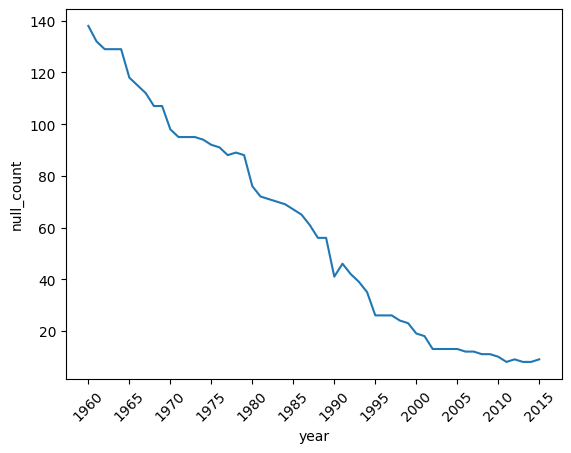

In [8]:
fig, ax = plt.subplots()
sns.lineplot(data=null_year_df_gdp, x='year', y='null_count')
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%5!=0:
        xticks[i].set_visible(False)
ax.set_xticklabels( years, rotation=45 )        
plt.show()

In [9]:
print(nutr_df.columns)

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', 'Unnamed: 60'],
      dtype='object')


In [10]:
num_nulls = nutr_df.isna().any(axis=1).sum()
num_nulls

89010

In [11]:
num_dups = nutr_df.duplicated().sum()
num_dups

0

There are 89010 nulls and 0 duplicates.

### Exploring Null Values

We will explore the null values to decide on how to deal with them.

In [12]:
#get the null counts for each year
null_year_df = pd.DataFrame()
years=[]
null_counts=[]
for year in range(1960, 2016):
  years.append(str(year))
  null_counts.append(nutr_df[str(year)].isna().sum())

null_year_df['year']=years
null_year_df['null_count']=null_counts

/var/folders/xv/rhx6787d1bn99c22j27k1q100000gn/T/ipykernel_95654/2392892120.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( years, rotation=45 )


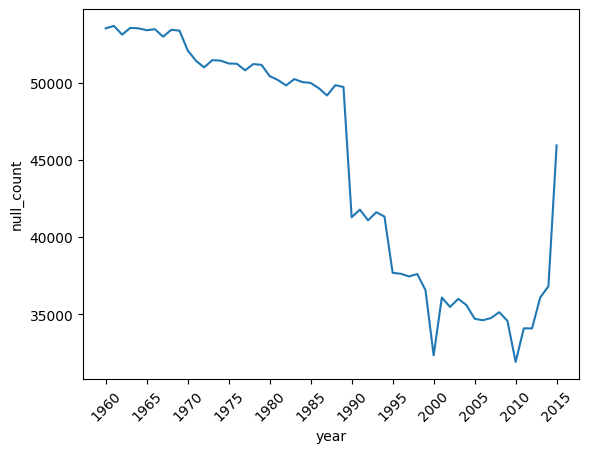

In [13]:
fig, ax = plt.subplots()
sns.lineplot(data=null_year_df, x='year', y='null_count')
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i%5!=0:
        xticks[i].set_visible(False)
ax.set_xticklabels( years, rotation=45 )        
plt.show()

The plot shows count of null values by years. There were a lot of null values before 1990, which could be explained by people not having access to some data or not monitoring the data at all. There is also an increase in null values in the 2015 data.

Some of the indicators are in terms of numbers, not %, so we will drop any Indicator name that does not contains the words 'rate' or '%' or 'per'.

In [14]:
nutr_df = nutr_df[(nutr_df['Indicator Name'].str.contains('%')) | (nutr_df['Indicator Name'].str.contains('rate')) | (nutr_df['Indicator Name'].str.contains('per'))]
#df = df[df['Indicator Code'].str.contains('rate|per')]


### Pivoting the table

We will pivot the indicators to the columns and years to the rows. 
We are pivoting indicators to columns to make future steps in training the model more straightforward. Having the indicators in columns will allow us to easily project the table to indicators of interest. We are pivoting the years to the rows to make it easier to remove None and Nan values by year rather than by row. In our EDA, we see that most rows contain at least one None/Nan value in the columns of early years since not much data was collected then.

In [15]:
nutr_df.columns
nutr_df.drop("Unnamed: 60", axis=1, inplace=True)

/var/folders/xv/rhx6787d1bn99c22j27k1q100000gn/T/ipykernel_95654/2748072469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nutr_df.drop("Unnamed: 60", axis=1, inplace=True)


In [16]:
melt_nutr_df = nutr_df.melt(id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"], var_name="Year", value_name="Value")
melt_nutr_df.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Value
0,Arab World,ARB,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,1960,NaN
1,Arab World,ARB,% of males ages 15-49 having comprehensive cor...,SH.HIV.KNOW.MA.ZS,1960,NaN
2,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,133.555013
3,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,87.799235
4,Arab World,ARB,Antiretroviral therapy coverage (% of people l...,SH.HIV.ARTC.ZS,1960,NaN


In [17]:
pivoted_df = melt_nutr_df.pivot_table(index=['Country Code', 'Year'], columns='Indicator Code', values='Value').reset_index()

pivoted_df.head(5)


Indicator Code,Country Code,Year,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,SE.PRM.CMPT.FE.ZS,...,SP.POP.TOTL.MA.ZS,SP.REG.BRTH.RU.ZS,SP.REG.BRTH.UR.ZS,SP.REG.BRTH.ZS,SP.REG.DTHS.ZS,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL.IN.ZS,SP.UWT.TFRT
0,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.022285,NaN,NaN,NaN,NaN,3.163869,49.224,3.106802,50.776,NaN
1,ABW,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.037612,NaN,NaN,NaN,NaN,2.271351,49.239,2.206183,50.761,NaN
2,ABW,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.032476,NaN,NaN,NaN,NaN,1.447561,49.254,1.386975,50.746,NaN
3,ABW,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.014939,NaN,NaN,NaN,NaN,0.866460,49.270,0.802881,50.730,NaN
4,ABW,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.994371,NaN,NaN,NaN,NaN,0.613827,49.285,0.554748,50.715,NaN


We will also pivot population table.

In [18]:
pivoted_df.head(5)

Indicator Code,Country Code,Year,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,SE.PRM.CMPT.FE.ZS,...,SP.POP.TOTL.MA.ZS,SP.REG.BRTH.RU.ZS,SP.REG.BRTH.UR.ZS,SP.REG.BRTH.ZS,SP.REG.DTHS.ZS,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL.IN.ZS,SP.UWT.TFRT
0,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.022285,NaN,NaN,NaN,NaN,3.163869,49.224,3.106802,50.776,NaN
1,ABW,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.037612,NaN,NaN,NaN,NaN,2.271351,49.239,2.206183,50.761,NaN
2,ABW,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.032476,NaN,NaN,NaN,NaN,1.447561,49.254,1.386975,50.746,NaN
3,ABW,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.014939,NaN,NaN,NaN,NaN,0.866460,49.270,0.802881,50.730,NaN
4,ABW,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.994371,NaN,NaN,NaN,NaN,0.613827,49.285,0.554748,50.715,NaN


In [19]:
num_null = melt_nutr_df["Value"].isnull().sum()
print("Number of rows where Value is null:", num_null)

Number of rows where Value is null: 1994589


In [20]:
melt_nutr_df.dropna(subset=['Value'], inplace=True)


## Correlation Matrix
In the following cells, we will determine which indicators have the greatest impact on a country's GDP. This will be done though by finding the correlation between the GDP and each indicator.

melt_nutr_df does not contain the GDP of the countries, so we will use another dataset on countries and their GDP values by years and join it with melt_nutr_df on country code.

There are a lot of NaN values for some years (earlier ones) was just not collected. We will remove NaN values since there is not a better way to deal with them.
We will also rename the value columns to make it clear which values are from nutritional datasets and which indicate the gdp of the country for the specific year.

pivoting gdp

In [21]:
melt_gdp_df = gdp_df.melt(id_vars=["Country Name", "Code"], var_name="Year", value_name="Value")
melt_gdp_df.head(5)
pivoted_df.head(5)

Indicator Code,Country Code,Year,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,SE.PRM.CMPT.FE.ZS,...,SP.POP.TOTL.MA.ZS,SP.REG.BRTH.RU.ZS,SP.REG.BRTH.UR.ZS,SP.REG.BRTH.ZS,SP.REG.DTHS.ZS,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL.IN.ZS,SP.UWT.TFRT
0,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.022285,NaN,NaN,NaN,NaN,3.163869,49.224,3.106802,50.776,NaN
1,ABW,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.037612,NaN,NaN,NaN,NaN,2.271351,49.239,2.206183,50.761,NaN
2,ABW,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.032476,NaN,NaN,NaN,NaN,1.447561,49.254,1.386975,50.746,NaN
3,ABW,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.014939,NaN,NaN,NaN,NaN,0.866460,49.270,0.802881,50.730,NaN
4,ABW,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.994371,NaN,NaN,NaN,NaN,0.613827,49.285,0.554748,50.715,NaN


In [22]:
#drop country name because this is available from nutritional dataset
melt_gdp_df = melt_gdp_df.drop(columns=['Country Name'])

In [26]:
#merge the two tables to get country's gdp for the given year
merged_gdp = pd.merge(pivoted_df, melt_gdp_df, left_on=['Country Code', 'Year'], right_on=['Code', 'Year'])
#rename columns
merged_gdp = merged_gdp.rename(columns={'Value': 'gdp_country'})
#get rid of NaN
merged_gdp.dropna(subset=['gdp_country'], inplace=True)


In [27]:
merged_gdp.dtypes

Country Code             object
Year                     object
NY.GNP.PCAP.CD          float64
SE.ADT.1524.LT.FM.ZS    float64
SE.ADT.1524.LT.MA.ZS    float64
                         ...   
SP.URB.GROW             float64
SP.URB.TOTL.IN.ZS       float64
SP.UWT.TFRT             float64
Code                     object
gdp_country             float64
Length: 221, dtype: object

In [28]:
merged_gdp.head(5)


,Country Code,Year,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,SE.PRM.CMPT.FE.ZS,...,SP.REG.BRTH.UR.ZS,SP.REG.BRTH.ZS,SP.REG.DTHS.ZS,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL.IN.ZS,SP.UWT.TFRT,Code,gdp_country
26,ABW,1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.580604,49.620,-0.641159,50.380,NaN,ABW,4.054634e+08
27,ABW,1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.269118,49.635,-1.330100,50.365,NaN,ABW,4.876025e+08
28,ABW,1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.202958,49.650,-1.263447,50.350,NaN,ABW,5.964236e+08
29,ABW,1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.042878,49.665,-0.104112,50.335,NaN,ABW,6.953044e+08
30,ABW,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.843551,49.681,1.780922,50.319,NaN,ABW,7.648871e+08


Some columns contain object types. Specifically, 'Indicator Name'is the columns we are interested in. We will use label encoding to map values to type int so we can use the columns in correlation matrix.

In [29]:
from sklearn.preprocessing import LabelEncoder
#drop because there exists 'Country Code' which is a duplicate
corr_gdp = merged_gdp.drop(columns=['Code'])

In [31]:
le = LabelEncoder()

#fitting encoder on the country codes and transform them to int
corr_gdp['Country Code'] = le.fit_transform(corr_gdp['Country Code'])
corr_gdp.head(5)

,Country Code,Year,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,SE.PRM.CMPT.FE.ZS,...,SP.REG.BRTH.RU.ZS,SP.REG.BRTH.UR.ZS,SP.REG.BRTH.ZS,SP.REG.DTHS.ZS,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL.IN.ZS,SP.UWT.TFRT,gdp_country
26,0,1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.580604,49.620,-0.641159,50.380,NaN,4.054634e+08
27,0,1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.269118,49.635,-1.330100,50.365,NaN,4.876025e+08
28,0,1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.202958,49.650,-1.263447,50.350,NaN,5.964236e+08
29,0,1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.042878,49.665,-0.104112,50.335,NaN,6.953044e+08
30,0,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.843551,49.681,1.780922,50.319,NaN,7.648871e+08


In [32]:
correlation_matrix = corr_gdp.corr()["gdp_country"][0:-1]


/var/folders/xv/rhx6787d1bn99c22j27k1q100000gn/T/ipykernel_95654/385456122.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = corr_gdp.corr()["gdp_country"][0:-1]


The plot is too big to visualize, so we will find the absolute value of each value in correlation matrix and pick the most influential ones.

In [33]:
corr_df = correlation_matrix.to_frame()
mask = corr_df.isnull().any(axis=1)
rows_with_nan = corr_df[mask]
print(rows_with_nan)

Empty DataFrame
Columns: [gdp_country]
Index: []


We will sort the gdp values to make graphs easier to interpret.

In [34]:
corr_df['gdp_country_original'] = corr_df['gdp_country'].copy()
corr_df['gdp_country'] = corr_df['gdp_country'].apply(lambda x:abs(x))

#unstacked = abs_val_corr.unstack()
sorted_corr = corr_df.sort_values(by='gdp_country', kind="quicksort", ascending=False)


In [35]:
sorted_corr

,gdp_country,gdp_country_original
SH.FPL.SATI.ZS,0.340277,0.340277
SP.POP.80UP.FE.5Y,0.320896,0.320896
SP.POP.80UP.MA.5Y,0.320179,0.320179
SH.XPD.PCAP.PP.KD,0.310141,0.310141
SH.XPD.PCAP,0.291871,0.291871
...,...,...
SH.STA.OWGH.FE.ZS,0.004889,0.004889
SH.STA.OWGH.MA.ZS,0.004379,-0.004379
SH.STA.BFED.ZS,0.004190,0.004190
SH.STA.DIAB.ZS,0.002568,-0.002568


In [36]:
sorted_corr_filtered = sorted_corr[sorted_corr['gdp_country'] > 0.25]


In [37]:
sorted_corr_filtered.head(5)

,gdp_country,gdp_country_original
SH.FPL.SATI.ZS,0.340277,0.340277
SP.POP.80UP.FE.5Y,0.320896,0.320896
SP.POP.80UP.MA.5Y,0.320179,0.320179
SH.XPD.PCAP.PP.KD,0.310141,0.310141
SH.XPD.PCAP,0.291871,0.291871


In [38]:
sorted_corr_filtered = sorted_corr_filtered.dropna(axis=1, how='any')

We need the indicator codes to be a column:

In [39]:
sort_melted = sorted_corr_filtered[['gdp_country_original']].T.melt(var_name='Indicator Code', value_name='Correlation')

In [40]:
sorted_corr_filtered[['gdp_country_original']].T

,SH.FPL.SATI.ZS,SP.POP.80UP.FE.5Y,SP.POP.80UP.MA.5Y,SH.XPD.PCAP.PP.KD,SH.XPD.PCAP,SH.XPD.TOTL.ZS,SP.POP.7579.MA.5Y,SH.XPD.OOPC.ZS,SI.POV.NAHC,SP.POP.1014.FE.5Y,...,SP.POP.5559.FE.5Y,SP.POP.7579.FE.5Y,SP.POP.1014.MA.5Y,SP.POP.5054.FE.5Y,SP.POP.0509.FE.5Y,SP.POP.4549.MA.5Y,SP.POP.6064.FE.5Y,SP.POP.4549.FE.5Y,SP.POP.0509.MA.5Y,SH.SGR.PROC.P5
gdp_country_original,0.340277,0.320896,0.320179,0.310141,0.291871,0.291433,0.288302,-0.287451,-0.275036,-0.273026,...,0.264199,0.262825,-0.262764,0.261764,-0.258239,0.256213,0.255979,0.254984,-0.254969,0.253091


Right now, the columns are in terms of Indicator Codes, which have no meaning to us. We will map the codes to the name of the indicators to make more sense of the results.

In [41]:
indicators_df =  melt_nutr_df[['Indicator Code', 'Indicator Name']]
indicator_dict = dict(zip(indicators_df['Indicator Code'], indicators_df['Indicator Name']))
correlation_ind_names = sorted_corr_filtered.T.rename(columns=indicator_dict)
correlation_ind_names = correlation_ind_names.T[['gdp_country_original']].T.melt(var_name='Indicator Name', value_name='Correlation')

In [42]:
correlation_ind_names.head(5)

,Indicator Name,Correlation
0,Demand for family planning satisfied by any me...,0.340277
1,"Population ages 80 and older, female (% of fem...",0.320896
2,"Population ages 80 and older, male (% of male ...",0.320179
3,"Health expenditure per capita, PPP",0.310141
4,Health expenditure per capita (current US$),0.291871


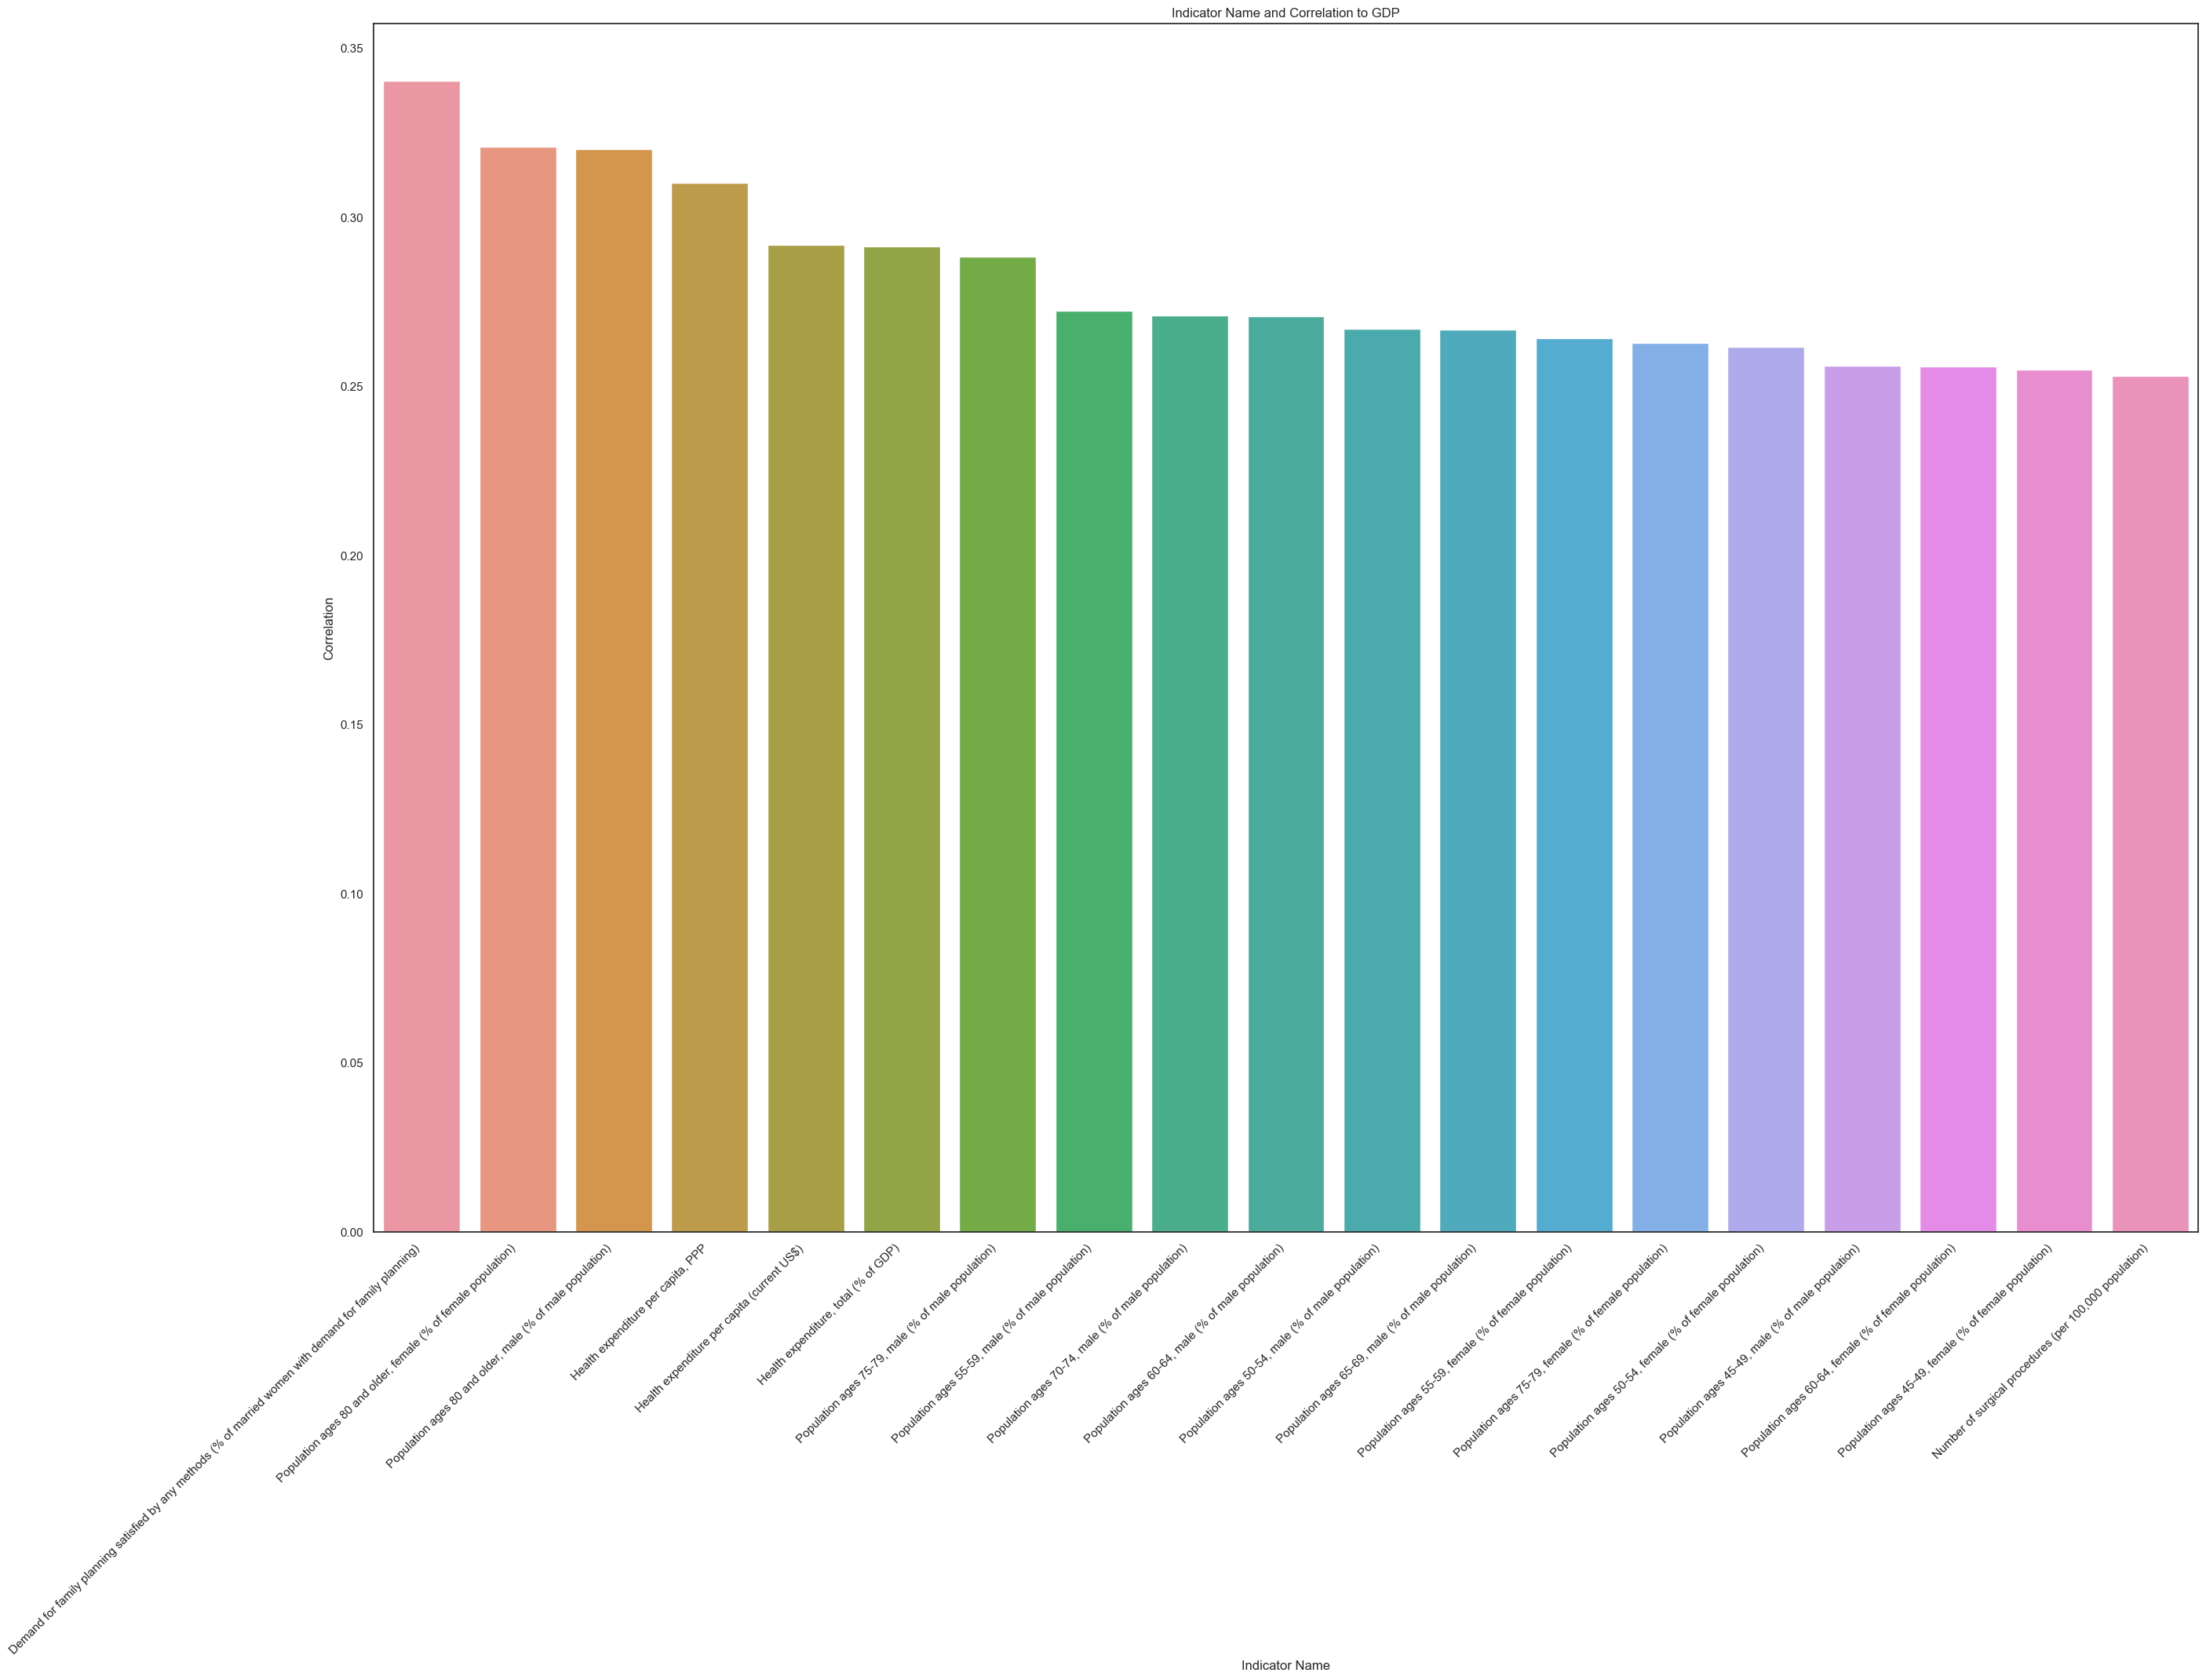

In [994]:
plt.figure(figsize=(30, 20))
ax = sns.barplot(x='Indicator Name', y ='Correlation', data = correlation_ind_names[correlation_ind_names['Correlation'] > 0])
plt.title('Indicator Name and Correlation to GDP')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.xlabel('Indicator Name')
plt.ylabel('Correlation')

plt.show()

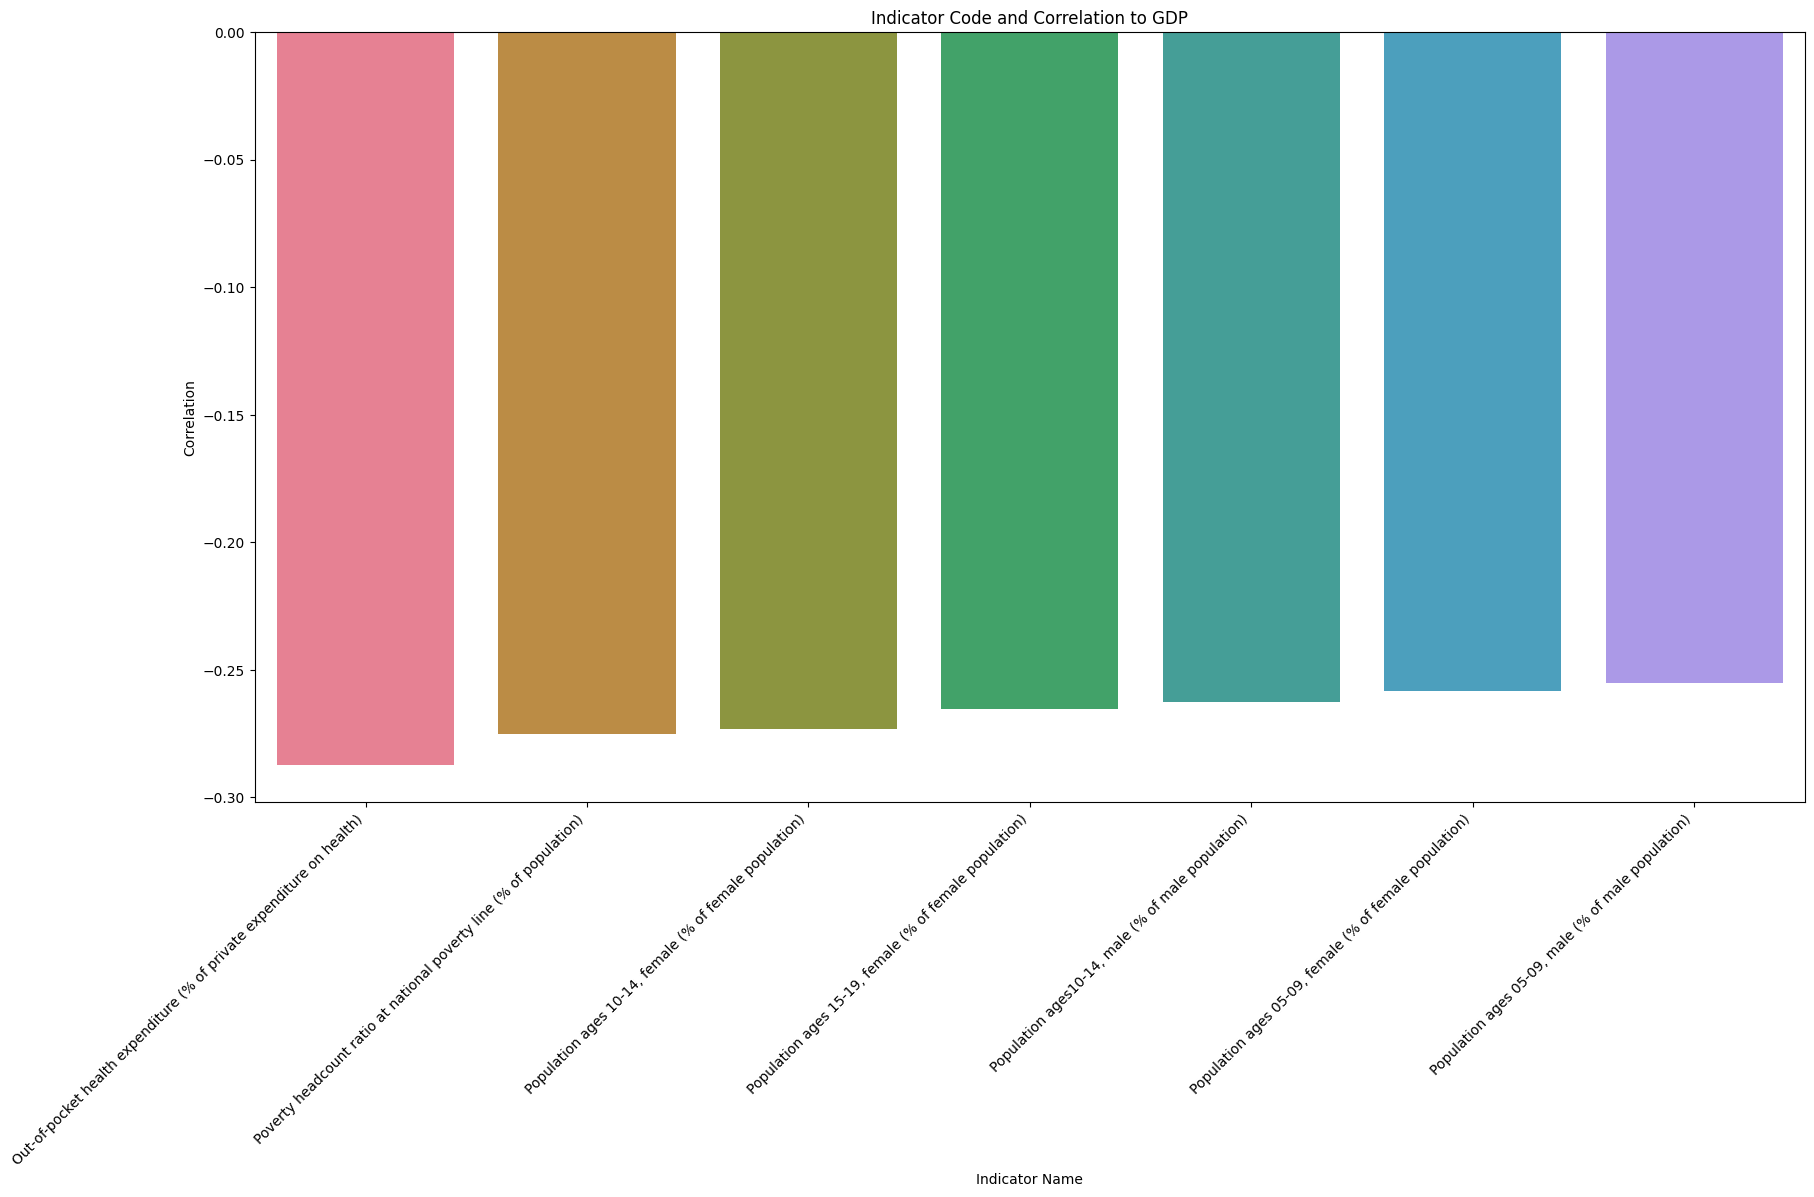

In [43]:
plt.figure(figsize=(20, 10))

ax = sns.barplot(x='Indicator Name', y ='Correlation', data =correlation_ind_names[correlation_ind_names['Correlation'] <=0], palette=sns.color_palette("husl", 8))
plt.title('Indicator Code and Correlation to GDP')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.xlabel('Indicator Name')
plt.ylabel('Correlation')

plt.show()

## Conclusion from Correlation Matrix

#### Positive Correlations

Highest positive correlation was revealed to be demand for family planning satisfied by any methods. We would expect this to be positively correlated with gdp because when families are able to use family planning, they have more income they are able to invest into education and infrastructure.

Many factors appear to involve population percentages of certain aged female and male populations. The population of specific ages can increase number of people who are able to work which increases the labor force of the country. The age that is most highly positively correlated with gdp is 80+, indicating that people in the country are healthier. 

Health expenditure is also moderately correlated with gdp. This is expected because spending mroe on health leads to less premature deaths, which increases the working age and leads to a decrease in illnesses. Number of surgical procedures was also moderately correlated with gdp. This could be explaine by surgeries implying better healthcare available for people, so they are able to be sick less.

#### Negative Correlations

Out of pocket health expenditure has a moderate negative correlation with gdp. This is expected because out-of-pocket expenditure may indicate poverty in the country so that the country is not able to cover some health services. Poeple would be spending a lot of their own money on health care and therefore will have no money left to invest into the country. 

Poverty headcount ratio at national poverty line also have a moderate negative correlation with gdp. This is expected because when country does not have as many resources to give to people, more people will suffer from lower income and therefore poverty. 

The last factors that had a moderate negative correlation with gdp were population ages younger than 19. This is expected because younger people do not have working expereince and some are too young to work. The country has to spend morer money into educating the children. Moreover, when a family grows, they will spend more income to take care of children rather than investing money and time into country's economic growth.

## Linear Regression

Define a linear regression model using the indicators with high correlation as features and GDP as the label

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
# TO-DO: Initialize model with default parameters and fit it on the training set
reg = LinearRegression()
reg.fit(X_train, y_train)

# TO-DO: Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = reg.predict(X_test)

# TO-DO: Find the R-squared score and store the value in `lin_reg_score`
lin_reg_score = r2_score(y_test, y_pred)

## Random Forest Regressor

## Clustering

Our last approach will be to use clustering to classify what bracket of GDP a country falls in. While this will not give an accurate GDP like the prediction models above, this fits the purpose of our project, which is to predict the welfare of a nation based on its socioeconomic and cultural metrics. It suffices to group certain ranges of GDPs and predict what group a particular country falls under

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Extract the features we want to include in the PCA
X = melt_nutr_df[['Year', 'Value']]

In [ ]:
# Standardize the features by subtracting the mean and scaling to unit variance
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Create a PCA object with 2 components
pca = PCA(n_components=2)

# Fit the PCA model to the standardized data
pca.fit(X_std)

# Transform the data to the new coordinate system
X_pca = pca.transform(X_std)

# Create a new DataFrame with the transformed data and the country labels
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Country'] = melt_nutr_df['Country Name']

# Print the explained variance of each principal component
print(pca.explained_variance_ratio_)

[0.50326287 0.49673713]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Aggregate the values for duplicate entries
melt_nutr_df_avg = melt_nutr_df.groupby(['Indicator Name', 'Country Name'])['Value'].mean().reset_index()
melt_nutr_df_avg

,Indicator Name,Country Name,Value
0,% of females ages 15-49 having comprehensive c...,Afghanistan,1.500000
1,% of females ages 15-49 having comprehensive c...,Albania,11.333333
2,% of females ages 15-49 having comprehensive c...,Algeria,10.700000
3,% of females ages 15-49 having comprehensive c...,Argentina,45.300000
4,% of females ages 15-49 having comprehensive c...,Armenia,19.033333
...,...,...,...
67995,Women's share of population ages 15+ living wi...,Vietnam,19.073451
67996,Women's share of population ages 15+ living wi...,World,49.354686
67997,Women's share of population ages 15+ living wi...,"Yemen, Rep.",32.095671
67998,Women's share of population ages 15+ living wi...,Zambia,56.782600
